## Graph Cuts implementation through GrabCuts OpenCV libraries

### Team #13

GrabCut is an image segmentation method based on graph cuts. Graph cuts model spatial coherence and color similarity, crucial for tasks like object extraction. By representing images as graphs and optimizing an energy function, GrabCut iteratively refines foreground and background regions based on pixel color distributions. This process, inspired by graph cut algorithms, accurately delineates objects from backgrounds while preserving details. Through graph cuts, GrabCut offers an efficient and robust solution for image segmentation, essential in various computer vision applications. In this Jupyter notebook, we'll explore GrabCut's implementation and how it effectively utilizes graph cuts for precise image segmentation. 

In [7]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from os import path

In [8]:
IMAGES_FOLDER = "data"
IMAGE = "spoon.jpg"

RGB_MAX_VALUE = 255

In [9]:
def show_image(image, title=None):
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.show()

Let's start by opening the original image and binarizing it for further processing.

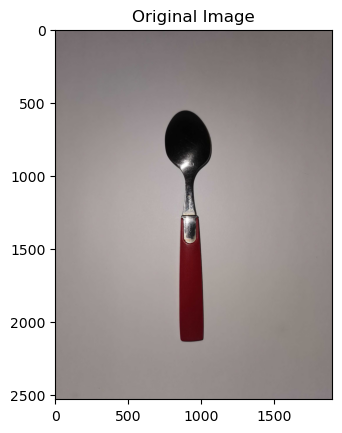

In [10]:
original_image = cv2.imread(path.join(IMAGES_FOLDER, IMAGE))
show_image(original_image, "Original image")

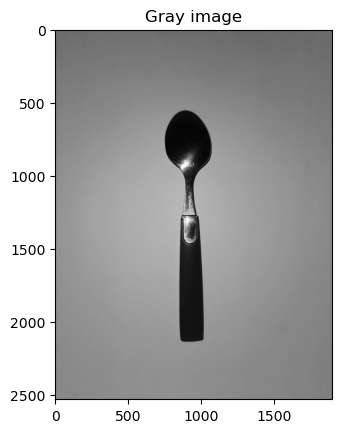

In [11]:
gray_image = cv2.cvtColor(original_image, cv2.COLOR_RGB2GRAY)
show_image(gray_image, "Gray image")

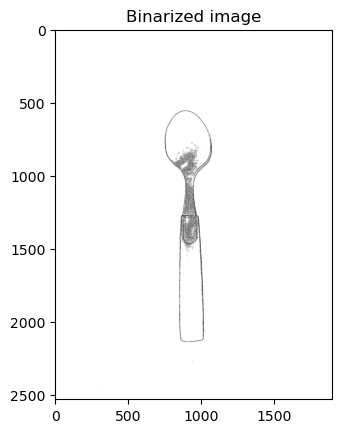

In [12]:
binarized_image = cv2.adaptiveThreshold(
    gray_image,
    maxValue=1,
    adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
    thresholdType=cv2.THRESH_BINARY,
    blockSize=9,
    C=7,
)
show_image(RGB_MAX_VALUE * binarized_image, "Binarized image")

Then, we can find the contours of the image.

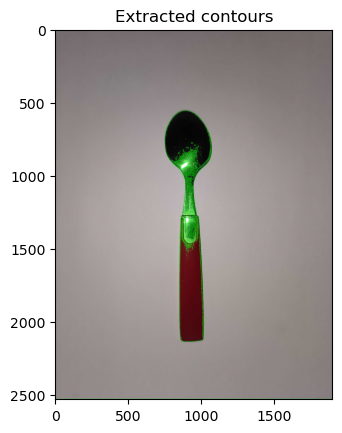

In [13]:
contours, hierarchy = cv2.findContours(
    binarized_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE
)
contours_image = cv2.drawContours(original_image.copy(), contours, -1, (0, RGB_MAX_VALUE, 0), 1)
show_image(contours_image, "Extracted contours")

Let's then define the GrabCut params and defining the bondaries manually, so that the spoon can be detected better.

In [ ]:
ITERATIONS = 5
HORIZONTAL_PROPORTIONS = 0.3
VERTICAL_PROPORTIONS = 0.1

In [14]:
cv2.setRNGSeed(0)
number_of_iterations = ITERATIONS

height, width, _ = original_image.shape
left_margin_proportion = HORIZONTAL_PROPORTIONS
right_margin_proportion = HORIZONTAL_PROPORTIONS
up_margin_proportion = VERTICAL_PROPORTIONS
down_margin_proportion = VERTICAL_PROPORTIONS

boundary_rectangle = (
    int(width * left_margin_proportion),
    int(height * up_margin_proportion),
    int(width * (1 - right_margin_proportion)),
    int(height * (1 - down_margin_proportion)),
)

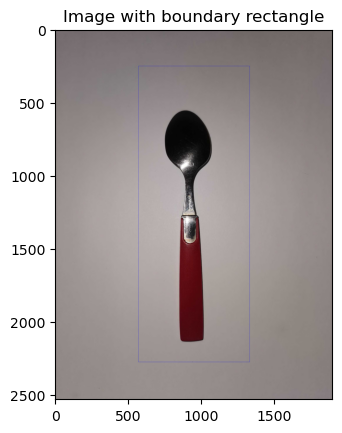

In [15]:
original_image_with_boundary_rectangle = cv2.rectangle(
    original_image.copy(),
    (int(width * left_margin_proportion), int(height * up_margin_proportion)),
    (
        int(width * (1 - right_margin_proportion)),
        int(height * (1 - down_margin_proportion)),
    ),
    (RGB_MAX_VALUE, 0, 0),
    1,
)
show_image(original_image_with_boundary_rectangle, "Image with boundary rectangle")

Let's try to initialize the algorithm only with the rectangle.

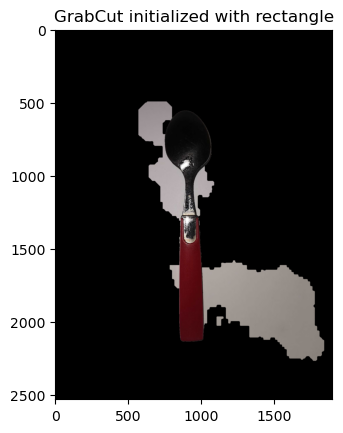

In [16]:
mask = np.zeros((height, width), np.uint8)

background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

cv2.grabCut(
    img=original_image,
    mask=mask,
    rect=boundary_rectangle,
    bgdModel=background_model,
    fgdModel=foreground_model,
    iterCount=number_of_iterations,
    mode=cv2.GC_INIT_WITH_RECT,
)

grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype("uint8")
segmented_image = original_image.copy() * grabcut_mask[:, :, np.newaxis]

show_image(segmented_image, "GrabCut initialized with rectangle")

Well... That didn't work as expected. Let's now try the algorithm with known information from the recatngle defined previously.

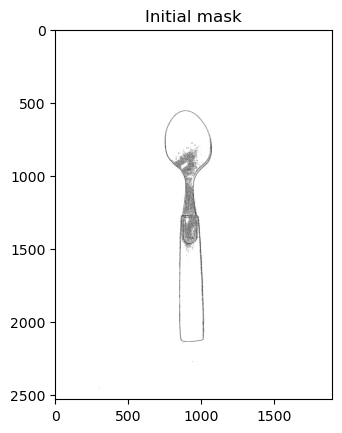

(array([[2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        ...,
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2],
        [2, 2, 2, ..., 2, 2, 2]], dtype=uint8),
 array([[9.39329799e-02, 0.00000000e+00, 1.12119394e-01, 7.64837507e-01,
         2.91101196e-02, 1.70904312e+02, 1.71626861e+02, 1.79882352e+02,
         1.22013642e+01, 1.22346861e+01, 1.24551355e+01, 1.23932693e+02,
         1.20933557e+02, 1.29933369e+02, 1.39912983e+02, 1.42316900e+02,
         1.50215921e+02, 1.43910995e+02, 1.43864007e+02, 1.50814191e+02,
         3.38320039e+01, 3.41866340e+01, 3.41137080e+01, 3.41866340e+01,
         3.93167544e+01, 3.82827303e+01, 3.41137080e+01, 3.82827303e+01,
         3.74589259e+01, 7.21514283e+01, 7.15456617e+01, 7.32129768e+01,
         7.15456617e+01, 7.12668473e+01, 7.29199736e+01, 7.32129768e+01,
         7.29199736e+01, 7.54434561e+01, 1.19454104e+02, 1.19427964e+02,
         1.19433167e+02, 1.19427964e+02, 1.1

In [19]:
initial_mask = binarized_image.copy()
show_image(RGB_MAX_VALUE * initial_mask, "Initial mask")

mask = np.zeros((height, width), np.uint8)
mask[:] = cv2.GC_PR_BGD
mask[initial_mask == 0] = cv2.GC_FGD

background_model = np.zeros((1, 65), np.float64)
foreground_model = np.zeros((1, 65), np.float64)

cv2.grabCut(
    original_image,
    mask,
    boundary_rectangle,
    background_model,
    foreground_model,
    number_of_iterations,
    cv2.GC_INIT_WITH_MASK,
)

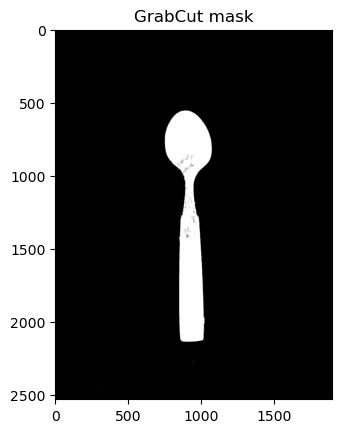

In [20]:
grabcut_mask = np.where((mask == cv2.GC_PR_BGD) | (mask == cv2.GC_BGD), 0, 1).astype("uint8")
show_image(RGB_MAX_VALUE * grabcut_mask, "GrabCut mask")

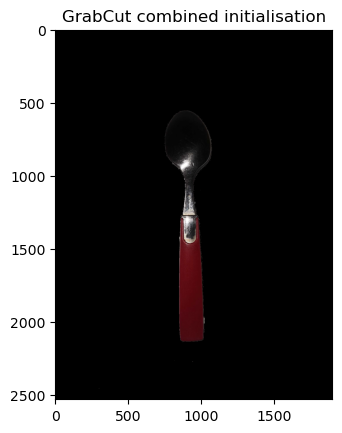

In [21]:
grabcut_image = original_image.copy() * grabcut_mask[:, :, np.newaxis]
show_image(grabcut_image, "GrabCut combined initialisation")

And that's it! We combinded known information with the GrabCut algorithm to actually get the desired object from a photo.

References:
- Joshi, V. A. P. B. P. (2013, 1 noviembre). Graph-Cuts in computer vision. Perpetual Enigma. https://prateekvjoshi.com/2013/06/30/graph-cuts-in-computer-vision/
- 16-385 Computer Vision, Spring 2020. (s. f.). http://www.cs.cmu.edu/~16385/
- GrabCut for Automatic Image Segmentation [OpenCV Tutorial]. (s. f.). https://www.sicara.fr/blog-technique/grabcut-for-automatic-image-segmentation-opencv-tutorial
- Rother, C., Kolmogorov, V., & Blake, A. (2023). GrabCut: Interactive foreground extraction using iterated graph cuts. En ACM eBooks (pp. 593-598). https://doi.org/10.1145/3596711.3596774